<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FUNCTIONS" data-toc-modified-id="FUNCTIONS-1">FUNCTIONS</a></span></li><li><span><a href="#0-Preliminaries" data-toc-modified-id="0-Preliminaries-2">0 Preliminaries</a></span><ul class="toc-item"><li><span><a href="#0.0-Importing-Packages-and-Modules" data-toc-modified-id="0.0-Importing-Packages-and-Modules-2.1">0.0 Importing Packages and Modules</a></span></li><li><span><a href="#0.1-Importing-data" data-toc-modified-id="0.1-Importing-data-2.2">0.1 Importing data</a></span></li></ul></li><li><span><a href="#1-Split-the-train-and-test-sets" data-toc-modified-id="1-Split-the-train-and-test-sets-3">1 Split the train and test sets</a></span></li><li><span><a href="#2-Data-preprocessing" data-toc-modified-id="2-Data-preprocessing-4">2 Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#2.1-Outliers-of-quantitative-data" data-toc-modified-id="2.1-Outliers-of-quantitative-data-4.1">2.1 Outliers of quantitative data</a></span></li><li><span><a href="#2.2-Encoding-categorical-features-and-scaling" data-toc-modified-id="2.2-Encoding-categorical-features-and-scaling-4.2">2.2 Encoding categorical features and scaling</a></span></li><li><span><a href="#2.3-Resampling-to-reduce-imbalance-of-the-dataset" data-toc-modified-id="2.3-Resampling-to-reduce-imbalance-of-the-dataset-4.3">2.3 Resampling to reduce imbalance of the dataset</a></span></li><li><span><a href="#2.4-Data-Visualization-after-preprocessing-(2D-projection)" data-toc-modified-id="2.4-Data-Visualization-after-preprocessing-(2D-projection)-4.4">2.4 Data Visualization after preprocessing (2D projection)</a></span></li></ul></li><li><span><a href="#3-Classification-model" data-toc-modified-id="3-Classification-model-5">3 Classification model</a></span><ul class="toc-item"><li><span><a href="#3.0-Metrics" data-toc-modified-id="3.0-Metrics-5.1">3.0 Metrics</a></span></li><li><span><a href="#3.1-Dummy-Classifier-(Baseline)" data-toc-modified-id="3.1-Dummy-Classifier-(Baseline)-5.2">3.1 Dummy Classifier (Baseline)</a></span><ul class="toc-item"><li><span><a href="#Scores" data-toc-modified-id="Scores-5.2.1">Scores</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-5.2.2">Confusion matrix</a></span></li></ul></li><li><span><a href="#3.2-Simple-Naive-Bayes-Classifier" data-toc-modified-id="3.2-Simple-Naive-Bayes-Classifier-5.3">3.2 Simple Naive Bayes Classifier</a></span><ul class="toc-item"><li><span><a href="#Scores" data-toc-modified-id="Scores-5.3.1">Scores</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-5.3.2">Confusion matrix</a></span></li></ul></li><li><span><a href="#3.3-Simple-LGBM-Classifier" data-toc-modified-id="3.3-Simple-LGBM-Classifier-5.4">3.3 Simple LGBM Classifier</a></span></li><li><span><a href="#3.3-Model-Selection-(PyCaret)" data-toc-modified-id="3.3-Model-Selection-(PyCaret)-5.5">3.3 Model Selection (PyCaret)</a></span><ul class="toc-item"><li><span><a href="#Setting-up-the-dataset" data-toc-modified-id="Setting-up-the-dataset-5.5.1">Setting up the dataset</a></span></li><li><span><a href="#Compare-5-models" data-toc-modified-id="Compare-5-models-5.5.2">Compare 5 models</a></span></li></ul></li><li><span><a href="#3.4-Bayesian-Optimisation-on-f5_score-(OptunaSearchCV)" data-toc-modified-id="3.4-Bayesian-Optimisation-on-f5_score-(OptunaSearchCV)-5.6">3.4 Bayesian Optimisation on f5_score (OptunaSearchCV)</a></span><ul class="toc-item"><li><span><a href="#Optimisation" data-toc-modified-id="Optimisation-5.6.1">Optimisation</a></span></li><li><span><a href="#Best-parameters" data-toc-modified-id="Best-parameters-5.6.2">Best parameters</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-5.6.3">Confusion matrix</a></span></li><li><span><a href="#Scores" data-toc-modified-id="Scores-5.6.4">Scores</a></span></li><li><span><a href="#Plot-scores-while-tuning-hyperparameters" data-toc-modified-id="Plot-scores-while-tuning-hyperparameters-5.6.5">Plot scores while tuning hyperparameters</a></span></li><li><span><a href="#Learning-curve" data-toc-modified-id="Learning-curve-5.6.6">Learning curve</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-5.6.7">Feature importance</a></span></li></ul></li><li><span><a href="#3.5-Bayesian-Optimisation-on-AUC-(OptunaSearchCV)" data-toc-modified-id="3.5-Bayesian-Optimisation-on-AUC-(OptunaSearchCV)-5.7">3.5 Bayesian Optimisation on AUC (OptunaSearchCV)</a></span></li><li><span><a href="#3.5-bis-Bayesian-Optimisation-on-average-precision-(ie-PR--curve-AUC)-(OptunaSearchCV)" data-toc-modified-id="3.5-bis-Bayesian-Optimisation-on-average-precision-(ie-PR--curve-AUC)-(OptunaSearchCV)-5.8">3.5 bis Bayesian Optimisation on average precision (ie PR  curve AUC) (OptunaSearchCV)</a></span></li><li><span><a href="#3.6-Bayesian-Optimisation-on-MCC-(OptunaSearchCV)" data-toc-modified-id="3.6-Bayesian-Optimisation-on-MCC-(OptunaSearchCV)-5.9">3.6 Bayesian Optimisation on MCC (OptunaSearchCV)</a></span></li><li><span><a href="#3.7-Bayesian-Optimisation-on-custom-gain_level_score-(OptunaSearchCV)" data-toc-modified-id="3.7-Bayesian-Optimisation-on-custom-gain_level_score-(OptunaSearchCV)-5.10">3.7 Bayesian Optimisation on custom gain_level_score (OptunaSearchCV)</a></span></li><li><span><a href="#3.8-Threshold-tuning" data-toc-modified-id="3.8-Threshold-tuning-5.11">3.8 Threshold tuning</a></span><ul class="toc-item"><li><span><a href="#ROC-curves-of-the-models" data-toc-modified-id="ROC-curves-of-the-models-5.11.1">ROC curves of the models</a></span></li><li><span><a href="#Find-the-best-threshold" data-toc-modified-id="Find-the-best-threshold-5.11.2">Find the best threshold</a></span></li></ul></li><li><span><a href="#Interpretability-of-the-best-model" data-toc-modified-id="Interpretability-of-the-best-model-5.12">Interpretability of the best model</a></span></li><li><span><a href="#4-Export-Models-and-Data" data-toc-modified-id="4-Export-Models-and-Data-5.13">4 Export Models and Data</a></span></li><li><span><a href="#BROUILLON" data-toc-modified-id="BROUILLON-5.14">BROUILLON</a></span></li></ul></li><li><span><a href="#FUNCTIONS" data-toc-modified-id="FUNCTIONS-6">FUNCTIONS</a></span></li></ul></div>

# "Implémentez un modèle de scoring"
_Building and optimizing a classification model_

References used for this notebook:

- ""

## FUNCTIONS

In [1]:
'''
Plots ROC Curve of a model and the baseline of a model
'''

def plot_roc_curve(y, y_pred_proba, name_model, color='b', fig=None, ax=None):
    
    
    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax
    
    # tests if a baseline is already existing (color black)
    leg = ax.get_legend()
    if leg is not None:
        baseline_on = not ('k' in [line.get_c() for line in leg.get_lines()])
    else:
        baseline_on = True

    ### BASELINE
    if baseline_on:
        # generate a no skill prediction (majority class)
        y_prob_baseline = [0 for _ in range(len(y))]
        # computes auc
        auc_baseline = roc_auc_score(y, y_prob_baseline)
        # calculate the curves
        fpr_baseline, tpr_baseline, _ = roc_curve(y, y_prob_baseline)
        # plot baseline
        ax.plot(fpr_baseline, tpr_baseline, linestyle='--', color='k',
                label='Baseline'+' (AUC={:.2f})'.format(auc_baseline))
        
    ### MODEL
    # calculate roc auc scores
    auc_model = roc_auc_score(y.values, y_pred_proba)
    # calculate the curves
    fpr_model, tpr_model, thresh = roc_curve(y, y_pred_proba)
    ax.plot(fpr_model, tpr_model, linestyle='-', color=color,
            marker=None, label=name_model+' (AUC={:.2f})'.format(auc_model))
    
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title("ROC Curve")
    ax.legend()
#         return plt

In [2]:
    
'''
Plots PR Curve of a model and the baseline of a model
'''    
       
def plot_pr_curve(y, y_pred_proba, name_model, color='r', fig=None, ax=None):
    
    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax
    
    # tests if a baseline is already existing (color black)
    leg = ax.get_legend()
    if leg is not None:
        baseline_on = not ('k' in [line.get_c() for line in leg.get_lines()])
    else:
        baseline_on = True
        
    if baseline_on:
        ### BASELINE
        # generate a no skill prediction (majority class)
        y_prob_baseline = [0 for _ in range(len(y))]
        # calculate pr auc scores
        prauc_baseline = average_precision_score(y, y_prob_baseline)
        # calculate pr curves
        prec_baseline, rec_baseline, _ = precision_recall_curve(y, y_prob_baseline)
        # plot the precision-recall curves
        baseline = len(y[y==1]) / len(y)
        ax.plot([0, 1], [baseline, baseline], color='k', linestyle='--',
                label='Baseline'+' (AUC={:.2f})'.format(prauc_baseline))
    
    ### MODEL
    # calculate pr auc scores
    prauc_model = average_precision_score(y.values, y_pred_proba) # auc of the precision recall is avg precision !!
    # calculate pr curves
    prec_model, rec_model, thresh = precision_recall_curve(y, y_pred_proba)
    # plot the precision-recall curves
    ax.plot(rec_model, prec_model, marker=None, color=color,
            label=name_model+' (AUC={:.2f})'.format(prauc_model))
    
    # axis labels
    ax.set_xlabel('Recall (TP/Ptrue)')
    ax.set_ylabel('Precision (TP/Ppred)')
    ax.set_title("Precision Recall Curve")
    ax.legend()
#     return plt

In [3]:
'''
Plots the roc curve, the precision recal curve of a model for the probability of a class n.
'''
    
def plot_roc_pr_threshold_tuning(y, X, name_model, model, n=1,
                                 optim_score='gain_level', n_thresh=30,
                                 figsize=(15,7), palette='tab10', verbose=False,
                                 li_scores=['accuracy','bal_accuracy','recall_score','precision_score',
                                            'f1_score','f5_score','cohen_kapp','mcc_score','gain_level']):

    # compute predict (default thresh 0.5)
    y_pred = model.predict(X)

    # get the probability of the model for class n
    y_pred_proba = model.predict_proba(X)
    y_pred_proba_n = y_pred_proba[:,n]


    fig = plt.figure(figsize=figsize)

    # plot roc curve
    ax1 = fig.add_subplot(2,2,1)
    plot_roc_curve(y, y_pred_proba_n, name_model, 'r', fig, ax1)
    
    # plot pr curve
    ax2 = fig.add_subplot(2,2,2)
    plot_pr_curve(y, y_pred_proba_n, name_model, 'b', fig, ax2)
    

    # ##### CURVE OF CHOOSEN SCORE as a function of threshold

    
    # Computes all the scores for some thresholds (column name)
    df_res = pd.DataFrame()
    for i, th in enumerate(np.linspace(0, 1, n_thresh), 1):

        # set threshold of the model for class n
        y_pred_proba_n_th = (y_pred_proba[:,n] >= th).astype(bool)
        # store into a dataframe
        df_res = model_scores(y, y_pred_proba_n_th, y_pred_proba_n,
                              th, df_res, li_scores)
        if verbose:
            print('\r', str(i)+f'/{n_thresh}')

    df_res = df_res.T.reset_index().rename(columns={'index': 'threshold'})

    thresh_max = df_res.loc[df_res[optim_score].argmax(), 'threshold']

    ax3 = fig.add_subplot(2,1,2)
    
    my_pal = sns.color_palette(palette, len(li_scores))
#     my_pal = ['b', 'r', 'g', 'purple', 'orange',
#              'pink', 'brown', 'yellow', 'grey']
    
    for sc, col in zip(li_scores, my_pal):
        df_res.plot('threshold', sc, marker=None, ax=ax3, label=sc, color=col)
    
    ax3.set_xlabel('threshold')
    ax3.set_ylabel('score')
    ax3.vlines(thresh_max, 0, 1, color='k', linestyle='dashed')   
    ax3.set_title("Effect of Threshold tuning on scores")
    ax3.legend(bbox_to_anchor=(1,1))
    
    # show the plot
    fig.suptitle(f'Threshold tuning for {name_model}', fontweight='bold')
    plt.grid()
#     plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return thresh_max, df_res

## 0 Preliminaries

### 0.0 Importing Packages and Modules

In [4]:
%pwd

Installations and importations required in the virtual environment.

In [5]:
from P7_functions import *

Importation of modules and packages. 

In [6]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [7]:
dictPdSettings = {'display.max_rows': 5000, 'display.width': 1000,
                  'display.max_colwidth': 1000,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

Additional functions

In [8]:
# To play audio text-to-speech during execution

from IPython.display import Audio
from gtts import gTTS
import io

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

### 0.1 Importing data

In [9]:
# import cleaned data

import dill

with open('..\PICKLES\dict_cleaned.pkl', 'rb') as file:
    dict_cleaned = dill.load(file)

In [10]:
# set SK_ID_CURR as the index (and thus exclude of the analysis)

X_train = dict_cleaned['X_train']
y_train = dict_cleaned['y_train']
X_test = dict_cleaned['X_test']

In [11]:
X_train.shape, X_test.shape, y_train.shape

((307511, 70), (48744, 70), (307511,))

In [12]:
X_train.dtypes.value_counts()

float64    56
object     11
int64       3
dtype: int64

In [13]:
X_test.dtypes.value_counts()

float64    56
object     11
int64       3
dtype: int64

In [14]:
# get categorical and quantitative columns

cat_cols = list(X_train.select_dtypes(exclude=[np.number]).columns)
quant_cols = list(X_train.select_dtypes(include=[np.number]).columns)

 ## 1 Split the train and test sets

In [15]:
len(X_train.columns)

70

We'll split the "X_train" data in X_tr and X_te.

X_tr will be used with cross-validation to find the best model and for hyperparameter tuning.

X_te will be used to evaluate the performance of the best models.

In [16]:
from sklearn.model_selection import train_test_split

# Splitting a training set and a test set
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train,
                                          train_size=0.8, shuffle=True,
                                          stratify=y_train,
                                          random_state=14)

In [17]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((246008, 70), (61503, 70), (246008,), (61503,))

In [18]:
y_tr.value_counts(normalize=True)

0   0.92
1   0.08
Name: TARGET, dtype: float64

In [19]:
y_te.value_counts(normalize=True)

0   0.92
1   0.08
Name: TARGET, dtype: float64

## 2 Data preprocessing

### 2.1 Outliers of quantitative data

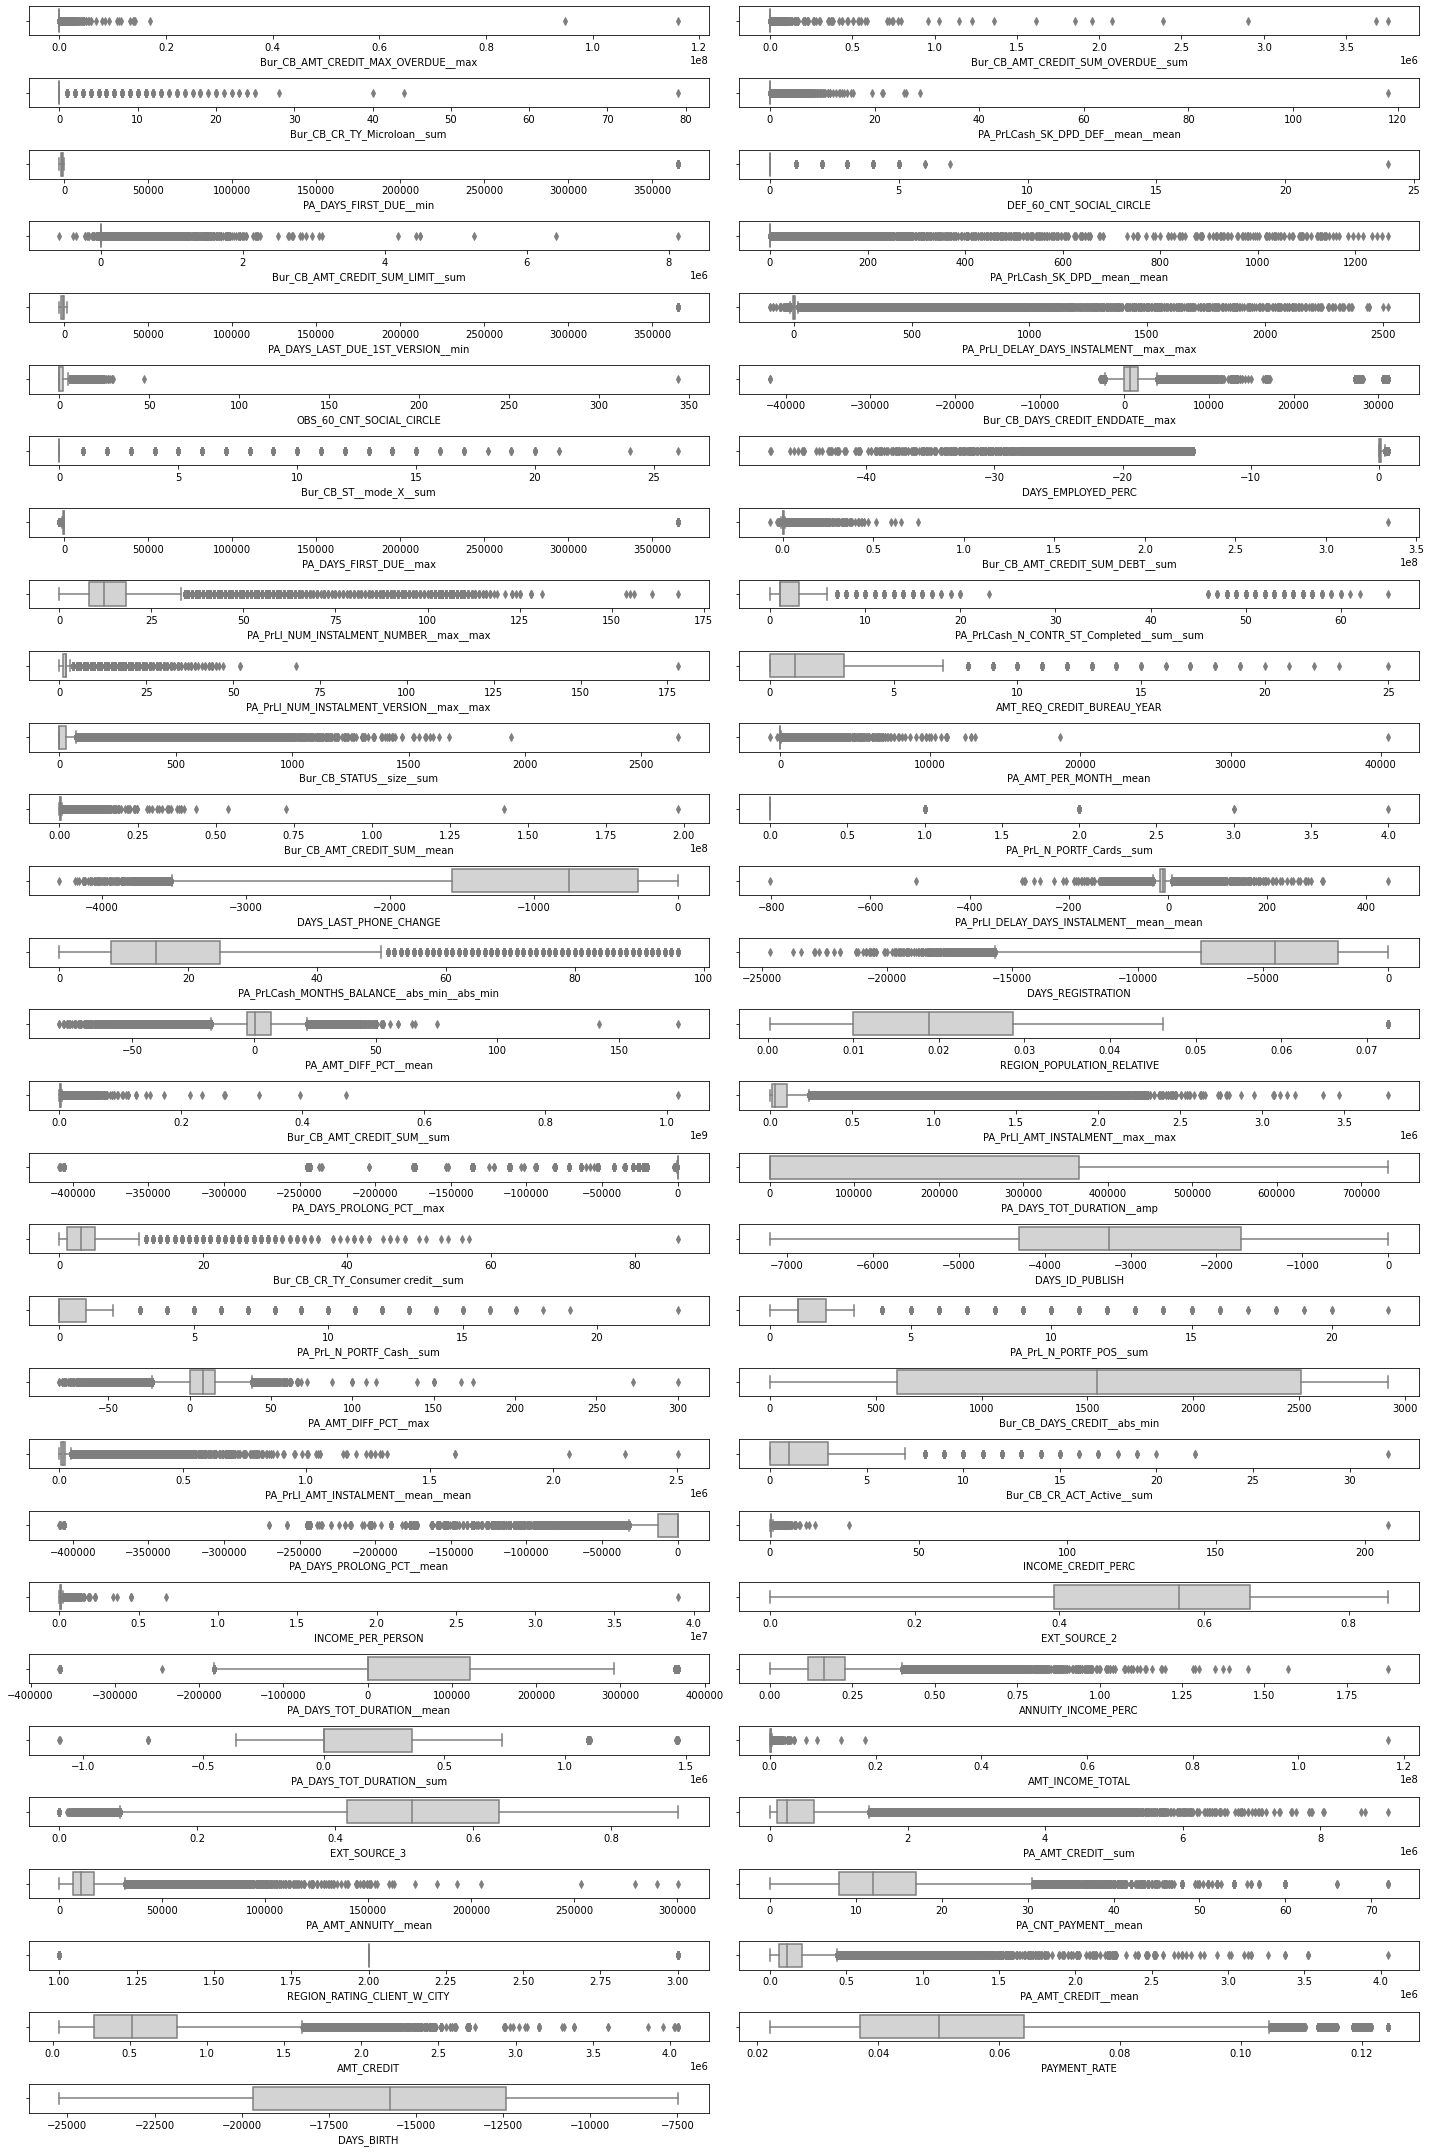

In [20]:
# Show outliers of each quantitative value

sel = quant_cols
width = 20
height = ((len(sel)+1)/2)*1

fig = plt.figure(figsize=(width, height))

for i, c in enumerate(sel,1):
    ax = fig.add_subplot((len(sel)+2)//2, 2, i)
    sns.boxplot(x=X_train[c], orient='h',
                color='lightgrey', ax=ax)
    
fig.tight_layout()

Some outliers may penalize the learning process.

We'll drop all the rows where a value is not within +/- 7 sigmas.

In [21]:
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

thresh = 7
minmax = MinMaxScaler()

# Minmax scaling of each column

ind_outliers = []
for col in quant_cols:
    ser_ = X_tr[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ind_outliers.append(list(ser_.loc[mask_outl].index))

ind_outliers = list(set([i for sublist in ind_outliers for i in sublist]))

print(f"{len(ind_outliers)} rows will be dropped, i.e. \
{100*len(ind_outliers)/X_tr.shape[0]}% of the rows of 'X_tr'")

12582 rows will be dropped, i.e. 5.114467822184644% of the rows of 'X_tr'


In [22]:
# verification that outliers are not all of the target=1 type

print(f"{100*y_tr.loc[ind_outliers].sum()/len(ind_outliers)}% of outliers are target=1")
print(f"{100*y_tr.sum()/y_train.shape[0]}% of all the rows are target=1")

9.632808774439676% of outliers are target=1
6.458305556549196% of all the rows are target=1


### 2.2 Encoding categorical features and scaling

We perform the following treatment on the data:
- Standardscaler (quantitative values)
- Binary (ordinal encoding)
- Categorical - low card (one hot encoding)
- Categorical - high card (ordinal encoding)

In [23]:
X_train.shape, X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((307511, 70), (246008, 70), (61503, 70), (246008,), (61503,))

In [24]:
# custom transformer

import warnings
warnings.filterwarnings('ignore')

ct = CustTransformer(thresh_card=12,
                     strat_quant='stand',
                     strat_binary='ord',
                     strat_low_card='ohe',
                     strat_high_card='loo')

ct.fit(X_tr, y_tr) # y_tr is here for 'loo'

X_tr_enc = ct.transform(X_tr) 
X_te_enc = ct.transform(X_te)

In [25]:
X_tr.shape, X_tr_enc.shape

((246008, 70), (246008, 95))

In [26]:
X_te.shape, X_te_enc.shape

((61503, 70), (61503, 95))

### 2.3 Resampling to reduce imbalance of the dataset

Several options are available when we  facing a imbalanced dataset:

- under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
- over-sampling when you don’t have a lot of data (tens of thousands of records or less)
- random and non-random (e.g. stratified) sampling schemes.
- different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

We'll choose :
- oversampling using SMOTE
- undersampling using all available target=1 objects and a random selection of the same number of target=0 objects.

In [27]:
# undersampling by hand...

ind1 = y_tr[y_tr==1].index
ind0 = y_tr[y_tr==0].sample(len(ind1)).index

samp_ind = list(set(list(ind0)+list(ind1)))

X_tr_undersamp = X_tr.loc[samp_ind]
X_tr_enc_undersamp = X_tr_enc.loc[samp_ind]
y_tr_undersamp = y_tr.loc[samp_ind]

In [28]:
# Oversampling using smote on X_tr_enc 

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', k_neighbors=5,
           n_jobs=-1, random_state=14) #'minority'

# NB: SMOTE works only on encoded data
X_tr_enc_oversamp, y_tr_oversamp = sm.fit_resample(X_tr_enc, y_tr)

Checking target value distribution on resampled data

In [29]:
X_tr_enc.shape, y_tr.shape

((246008, 95), (246008,))

In [30]:
X_tr_enc_oversamp.shape, y_tr_oversamp.shape

((452296, 95), (452296,))

In [31]:
X_tr_undersamp.shape, X_tr_enc_undersamp.shape, y_tr_undersamp.shape

((39720, 70), (39720, 95), (39720,))

Checking balance of data

In [32]:
y_tr_oversamp.value_counts(normalize=True)

1   0.50
0   0.50
Name: TARGET, dtype: float64

In [33]:
y_tr_undersamp.value_counts(normalize=True)

1   0.50
0   0.50
Name: TARGET, dtype: float64

### 2.4 Data Visualization after preprocessing (2D projection)

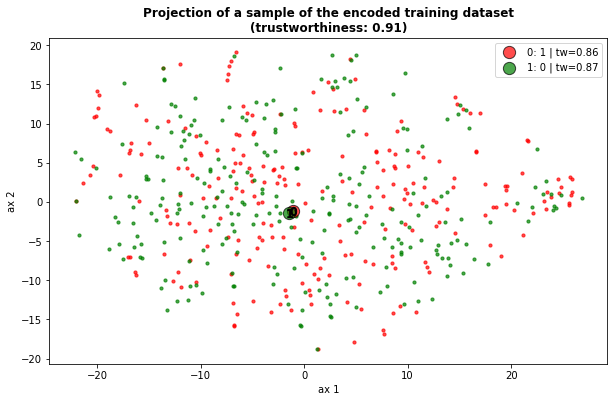

In [34]:
# Projection of a sample of the training set, colored with target value

ind_samp = X_tr_undersamp.sample(500).index

plot_projection(X=X_tr_enc_undersamp.loc[ind_samp],
                y=y_tr_undersamp.loc[ind_samp],
                model=None, 
                ser_clust = y_tr_undersamp.loc[ind_samp],
                proj='t-SNE', # dum_class # PCA, UMAP, t-SNE
                tw_n_neigh=5,
                title="Projection of a sample of the encoded training dataset",
                bboxtoanchor=None,
                figsize=(10, 6),
                size=10, palette=['r','g'],
                legend_on=False,
                fig=None, ax=None, random_state=14)

## 3 Classification model

### 3.0 Metrics

In [35]:
from sklearn.metrics import *

# Create appropriate scorer for imbalanced data in order to optimize later the models

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

precision_scorer = make_scorer(precision_score, greater_is_better=True)
recall_scorer = make_scorer(recall_score, greater_is_better=True)

f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_scorer = make_scorer(fbeta_score, beta=5, greater_is_better=True)

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
pr_auc_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

kappa_scorer = make_scorer(cohen_kappa_score, greater_is_better=True)
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

def gain_level(y_true, y_pred):

    rate_gain = 0.1
    rate_loss = -1

    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    actual_gain = (fn * rate_loss + tn * rate_gain)  # à maximiser
    # cas où aucun des défauts de paiement n'est détecté (pertes pour tous) et aucun prêt remboursé n'est accordé
    min_gain = (fn+tp) * rate_loss
    # cas où tous les défauts de paiement sont détectés (aucune perte) et tous les prêts remboursés sont accordés
    max_gain =  (tn+fp) * rate_gain
    # gain_level : ratio of the actual gain factor to the amplitude of gain
    return (actual_gain - min_gain) / (max_gain - min_gain)

gain_level_scorer = make_scorer(gain_level, greater_is_better=True) # needs_proba=False

In [36]:
# # test to compute myself the area under the curve of pr curve
# def agv_prec_custom(y_true, y_pred_proba):
#     precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
#     return auc(precision, recall)  # auc(recall, precision)

# pr_auc_scorer2 = make_scorer(agv_prec_custom, greater_is_better=True, needs_proba=True)

In [37]:
# compute and return all the specified scores

def model_scores(y_t, y_p, y_proba, title, df=None,
                 li_scores=['accuracy','bal_accuracy','recall_score','precision_score',
                            'f1_score','f5_score','roc_auc_score','pr_auc_score',
                            'cohen_kapp','mcc_score','gain_level']):
    
    if y_proba is None:
        li_scores = [sc for sc in li_scores if sc not in ['roc_auc_score','pr_auc_score']]
    
    dict_score_func = {'accuracy': (accuracy_score,(y_t, y_p)),
                       'bal_accuracy': (balanced_accuracy_score,(y_t, y_p)),
                       'recall_score': (recall_score, (y_t, y_p)),
                       'precision_score': (precision_score, (y_t, y_p)),
                       'f1_score': (f1_score, (y_t, y_p)),
                       'f5_score':  (fbeta_score, (y_t, y_p, 5)), # favoring recall
                       'roc_auc_score':  (roc_auc_score, (y_t, y_proba)),
                       'pr_auc_score':  (average_precision_score, (y_t, y_proba)), # area under the pr curve
                       'cohen_kapp' : (cohen_kappa_score, (y_t, y_p)),
                       'mcc_score' : (matthews_corrcoef, (y_t, y_p)),
                       'gain_level' : (gain_level, (y_t, y_p))}
               
    scores = []
    for sc in li_scores:
        scores.append(dict_score_func[sc][0](*dict_score_func[sc][1]))
        
    ser = pd.Series(scores, index=li_scores)
    
    df = pd.DataFrame() if df is None else df
    df[title] = ser
    
    return df

### 3.1 Dummy Classifier (Baseline)

In [38]:
from sklearn.dummy import DummyClassifier

dum_class = DummyClassifier(strategy='most_frequent',
                            random_state=14)

dum_class.fit(X_tr_enc, y_tr)

DummyClassifier(random_state=14, strategy='most_frequent')

#### Scores

In [39]:
df_res = pd.DataFrame()

# Computes scores

y_pred_tr = dum_class.predict(X_tr_enc)
y_pred_proba_tr = dum_class.predict_proba(X_tr_enc)[:,1]
df_res = model_scores(y_tr, y_pred_tr, y_pred_proba_tr, 'dummy_tr', df_res)

y_pred_te = dum_class.predict(X_te_enc)
y_pred_proba_te = dum_class.predict_proba(X_te_enc)[:,1]
df_res = model_scores(y_te, y_pred_te, y_pred_proba_te, 'dummy_te', df_res)

df_res

,dummy_tr,dummy_te
accuracy,0.92,0.92
bal_accuracy,0.50,0.50
recall_score,0.00,0.00
precision_score,0.00,0.00
f1_score,0.00,0.00
f5_score,0.00,0.00
roc_auc_score,0.50,0.50
pr_auc_score,0.08,0.08
cohen_kapp,0.00,0.00
mcc_score,0.00,0.00


#### Confusion matrix

In [40]:
# computes confusion matrix

cm_te = pd.crosstab(y_te.replace({0: 'repaid (true val)',
                                  1: 'not repaid (true val)'}).rename('True values').values,
                    pd.Series(y_pred_te).replace({0: 'repaid (pred val)',
                                               1: 'not repaid (pred val)'}).rename('Pred values').values)

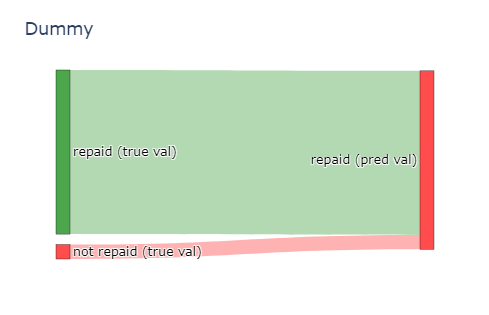

In [41]:
# to get interactive sankey confusion graph

# plot_sankey_confusion_mat(cm_te, static=False, figsize=(0.2, 0.7),
#                           font_size=14, palette=['r', 'g'])

# to get static sankey confusion graph
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm_te, static=True, font_size=18, title='Dummy',
                                      figsize=(1, 3), scale = 0.7, palette=['r', 'g'])
Image(img_bytes)

### 3.2 Simple Naive Bayes Classifier

Trained on encoded, oversampled dataset.

In [42]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import cross_val_score

gnb_class = GaussianNB(priors=None,
                       var_smoothing=1e-9)

# # fit the model
# gnb_class.fit(X_tr_enc, y_tr)
# gnb_class.fit(X_tr_enc_undersamp, y_tr_undersamp) 
gnb_class.fit(X_tr_enc_oversamp, y_tr_oversamp) 

GaussianNB()

#### Scores

In [43]:
# Computes scores (data not resampled)

y_pred_tr = gnb_class.predict(X_tr_enc)
y_pred_proba_tr = gnb_class.predict_proba(X_tr_enc)[:,1]
df_res = model_scores(y_tr, y_pred_tr, y_pred_proba_tr, 'gnb_tr_over', df_res)

y_pred_te = gnb_class.predict(X_te_enc)
y_pred_proba_te = gnb_class.predict_proba(X_te_enc)[:,1]
df_res = model_scores(y_te, y_pred_te, y_pred_proba_te, 'gnb_te_over', df_res)

df_res

,dummy_tr,dummy_te,gnb_tr_over,gnb_te_over
accuracy,0.92,0.92,0.29,0.29
bal_accuracy,0.50,0.50,0.55,0.54
recall_score,0.00,0.00,0.86,0.85
precision_score,0.00,0.00,0.09,0.09
f1_score,0.00,0.00,0.16,0.16
f5_score,0.00,0.00,0.65,0.64
roc_auc_score,0.50,0.50,0.63,0.63
pr_auc_score,0.08,0.08,0.14,0.14
cohen_kapp,0.00,0.00,0.02,0.02
mcc_score,0.00,0.00,0.06,0.06


#### Confusion matrix

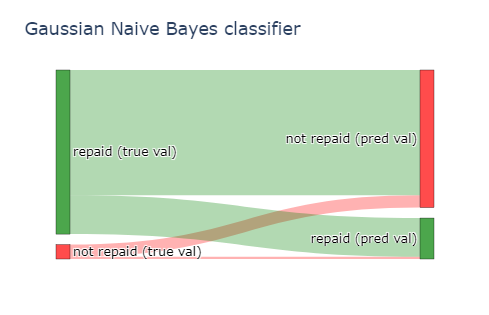

In [44]:
# computes confusion matrix
cm_te = pd.crosstab(y_te.replace({0: 'repaid (true val)',
                                  1: 'not repaid (true val)'}).rename('True values').values,
                    pd.Series(y_pred_te).replace({0: 'repaid (pred val)',
                                               1: 'not repaid (pred val)'}).rename('Pred values').values)

# # to get interactive sankey confusion graph
# plot_sankey_confusion_mat(cm_te, static=False, figsize=(0.2, 0.7),
#                           font_size=14, palette=['r', 'g'],
#                          title="Gaussian Naive Bayes classifier")

# to get static sankey confusion graph
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm_te, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 0.7, palette=['r', 'g'],
                                     title = "Gaussian Naive Bayes classifier")
Image(img_bytes)

### 3.3 Simple LGBM Classifier

Trained on encoded, oversampled dataset with no optimization of hyperparameters

In [45]:
from lightgbm import LGBMClassifier
# from sklearn.model_selection import cross_val_score

lgbm_class = LGBMClassifier()

# # fit the model
# lgbm_class.fit(X_tr_enc, y_tr)
# lgbm_class.fit(X_tr_enc_undersamp, y_tr_undersamp) 
lgbm_class.fit(X_tr_enc_oversamp, y_tr_oversamp) 

LGBMClassifier()

In [46]:
# Computes scores (data not resampled)

y_pred_tr = lgbm_class.predict(X_tr_enc_oversamp)
y_pred_proba_tr = lgbm_class.predict_proba(X_tr_enc_oversamp)[:,1]
df_res = model_scores(y_tr_oversamp, y_pred_tr, y_pred_proba_tr, 'lgbm_tr_over', df_res)

y_pred_tr = lgbm_class.predict(X_tr_enc)
y_pred_proba_tr = lgbm_class.predict_proba(X_tr_enc)[:,1]
df_res = model_scores(y_tr, y_pred_tr, y_pred_proba_tr, 'lgbm_tr', df_res)

y_pred_te = lgbm_class.predict(X_te_enc)
y_pred_proba_te = lgbm_class.predict_proba(X_te_enc)[:,1]
df_res = model_scores(y_te, y_pred_te, y_pred_proba_te, 'lgbm_te', df_res)

df_res

,dummy_tr,dummy_te,gnb_tr_over,gnb_te_over,lgbm_tr_over,lgbm_tr,lgbm_te
accuracy,0.92,0.92,0.29,0.29,0.96,0.92,0.92
bal_accuracy,0.50,0.50,0.55,0.54,0.96,0.51,0.51
recall_score,0.00,0.00,0.86,0.85,0.91,0.03,0.03
precision_score,0.00,0.00,0.09,0.09,1.00,0.54,0.51
f1_score,0.00,0.00,0.16,0.16,0.95,0.05,0.05
f5_score,0.00,0.00,0.65,0.64,0.92,0.03,0.03
roc_auc_score,0.50,0.50,0.63,0.63,0.98,0.78,0.76
pr_auc_score,0.08,0.08,0.14,0.14,0.99,0.26,0.24
cohen_kapp,0.00,0.00,0.02,0.02,0.91,0.04,0.04
mcc_score,0.00,0.00,0.06,0.06,0.91,0.11,0.10


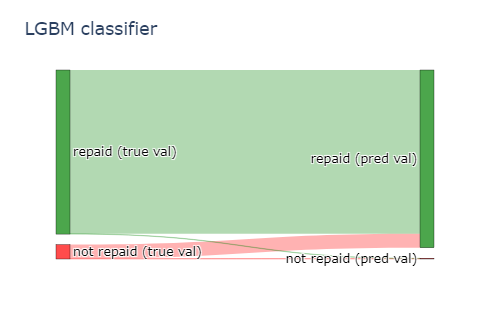

In [47]:
# computes confusion matrix
cm_te = pd.crosstab(y_te.replace({0: 'repaid (true val)',
                                  1: 'not repaid (true val)'}).rename('True values').values,
                    pd.Series(y_pred_te).replace({0: 'repaid (pred val)',
                                               1: 'not repaid (pred val)'}).rename('Pred values').values)

# # to get interactive sankey confusion graph
# plot_sankey_confusion_mat(cm_te, static=False, figsize=(0.2, 0.7),
#                           font_size=14, palette=['r', 'g'],
#                          title="Gaussian Naive Bayes classifier")

# to get static sankey confusion graph
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm_te, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 0.7, palette=['r', 'g'],
                                     title = "LGBM classifier")
Image(img_bytes)

### 3.3 Model Selection (PyCaret)

We'll use PyCaret to proceed to a fast spot checking of different classification models.

We'll use non encoded, not yet resampled dataset and let PyCaret take care of encoding and resampling.

In [48]:
# check pycaret version

import pycaret
print('PyCaret: %s' % pycaret.__version__)

PyCaret: 2.2.0


In [49]:
from pycaret.classification import *

#### Setting up the dataset

In [50]:
# setup the dataset

data = pd.concat([X_tr, y_tr], axis=1)
grid = setup(data=data,
             target='TARGET',
             fix_imbalance=True,
             data_split_stratify=True,
             remove_outliers=True,
             outliers_threshold=0.05,
             fold=7,
             use_gpu=False,
             profile=False,
             html=False,
             silent=True,
             verbose=False)

In [51]:
X_tr.shape, y_tr.shape

((246008, 70), (246008,))

In [52]:
# to get the training set effectively used to train the model

X_train_pycaret = get_config('X_train')
y_train_pycaret = get_config('y_train')

In [53]:
X_train_pycaret.shape, y_train_pycaret.shape

((163594, 140), (163594,))

In [54]:
# check out the available models

models(raise_errors=True)

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


We choose 5 models to try out:
['lightgbm','ada', 'lda','rf','svm']

#### Compare 5 models

In [55]:
import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_PyCaret.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         best_models = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # compare machine learning algorithms on preprocessed data (encoded and resampled)
    best_models = compare_models(
                                 include=['lightgbm','ada', 'lda','rf','svm'],
                                 fold=4,
                                 cross_validation=True,
                                 sort='AUC',
                                 n_select=10,
                                 budget_time=None,
                                 verbose=False # print results as it is computed
                                )

----- Model already exists - loading ...
----- Model loaded.


In [56]:
# ### Pickling the model

# import dill

# with open('..\\PICKLES\\P7_04_PyCaret.pkl', 'wb') as file:
#     dill.dump(best_models, file)

In [57]:
# get the results in a dataframe

best_models_scores_df = pull()
best_models_scores_df

In [58]:
# put the best models in a dictionary

dict_models = {model_name: model for model_name, model in zip(best_models_scores_df.index, best_models)}
# dict_models = {(str(m)).split('(')[0]: m for m in best_models}

AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
# Computes scores of all models

li_scores=['accuracy','bal_accuracy','recall_score','precision_score',
           'f1_score','f5_score','roc_auc_score','pr_auc_score',
           'cohen_kapp','mcc_score','gain_level']
df_pycaret = pd.DataFrame()

for n_model in list(dict_models.keys()):
    
    model = dict_models[n_model]
    
    data_tr = pd.concat([X_tr, y_tr], axis=1)
    prediction = predict_model(model, data=data_tr)
    if 'Score' in prediction.columns:
        y_proba = prediction['Score']
    else:
        y_proba = None
    df_pycaret = model_scores(y_t=prediction['TARGET'],
                              y_p=prediction['Label'],
                              y_proba=y_proba,
                              title=n_model+'_tr',
                              df=df_pycaret,
                              li_scores=li_scores)
    
    data_te = pd.concat([X_te, y_te], axis=1)
    prediction = predict_model(model, data = data_te)
    if 'Score' in prediction.columns:
        y_proba = prediction['Score']
    else:
        y_proba = None
    df_pycaret = model_scores(y_t=prediction['TARGET'],
                              y_p=prediction['Label'],
                              y_proba=y_proba,
                              title=n_model+'_te',
                              df=df_pycaret,
                              li_scores=li_scores)

df_pycaret

In [ ]:
#### VERIFIER QUE LA REPARATION MARCHE

from ipywidgets import interact
@interact
def plot_inter_sankey(model_name=(list(dict_models.keys())), y_name=['X_tr', 'X_te']):
    # Computes scores
    model = dict_models[model_name]
    
    if y_name =='X_te':
        data = data_tr
#         X = X_te_enc
#         y = y_te
    else:
        data = data_te
#         X = X_tr_enc
#         y = y_tr
        
    y_pred = model.predict(X)
    prediction = predict_model(model, data=data)
    
    cm = pd.crosstab(y.replace({0: 'repaid (true val)',
                                1: 'not repaid (true val)'}).rename('True values').values,
                    pd.Series(prediction['Label']).replace({0: 'repaid (pred val)',
                                                            1: 'not repaid (pred val)'})\
                                                  .rename('Pred values').values)
    plot_sankey_confusion_mat(cm, static=False, figsize=(0.2, 0.7),
                              font_size=14, palette=['r', 'g'],
                              title=f"PyCaret Classifier : {model_name} on {y_name} dataset")

In [ ]:
## A FAIRE : tester undersampling intelligent

### 3.4 Bayesian Optimisation on f5_score (OptunaSearchCV)

All the following steps are included in a pipeline:

- encoding of categorical data and scaling of quantitative data
- oversampling using SMOTE
- feature selection using SelectFromModel (lgbm)
- classification using lgbm

Input data are thus not encoded and not yet resampled.

In [ ]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree
# ‘dart’, Dropouts meet Multiple Additive Regression Trees
# ‘goss’, Gradient-based One-Side Sampling
# ‘rf’, Random Forest

In [ ]:
# num_boost_round=500,
# early_stopping_rounds

#### Optimisation

In [ ]:
### OptunaSearchCV

import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8,
                                                strat_binary='ord',
                                                strat_low_card='ohe',
                                                strat_high_card='loo',
                                                strat_quant='stand'
                                               )), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
#                     ('resamp', SMOTE(random_state=14)), # resampling,
                    ('featsel', SelectFromModel(LGBMClassifier())), # resampling,
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

param_distributions = {    
                       'preproc__strat_binary': CatDist(['ord']),
                        'preproc__strat_low_card': CatDist(['ohe']),
                        'preproc__strat_high_card': CatDist(['loo', 'bin']),
                        'preproc__strat_quant': CatDist(['stand']),
# #                   'resamp__k_neighbors': [5,10],
                    'featsel__max_features': IntUniDist(5, 80),
#  #             'outl_filter__n_estimators': [50,100],
                'clf__boosting_type': CatDist(['gbdt']), #'rf', 'dart', 'goss'
                'clf__extra_trees': CatDist([True, False]),
                'clf__is_unbalance': CatDist([True]),
                'clf__n_estimators': IntUniDist(10, 2000),
                'clf__num_leaves': IntUniDist(10, 200),
                'clf__reg_alpha': LogUniDist(1e-5, 1e0),
                'clf__reg_lambda':  LogUniDist(1e-3, 1e0),
                'clf__learning_rate': LogUniDist(1e-4, 1e-1),
                'clf__max_depth': IntUniDist(-1,5),
                }

optuna_search1 = optuna.integration.OptunaSearchCV(
                                                  pipe,
                                                  param_distributions,
                                                  n_trials=None,
                                                  timeout=3600, # 10 minutes
                                                  verbose=2,
                                                  refit=True,
                                                  scoring=f5_scorer, # gain_level_scorer
                                                  cv=4,
                                                  return_train_score=True
                                                  )

In [ ]:
import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_optsearch1.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         optuna_search1 = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # lauch Optuna optimization of the pipeline
#     ind_samp = X_tr.sample(100000).index # 100 000
    optuna_search1.fit(X_tr,#.loc[ind_samp],
                      y_tr)#.loc[ind_samp])
    model1 = optuna_search1.best_estimator_

In [ ]:
### Pickling the model

import dill

with open('..\\PICKLES\\P7_04_optsearch1.pkl', 'wb') as file:
    dill.dump(optuna_search1, file)

#### Best parameters

In [ ]:
# print the parameters of the best trial

print("Best trial on {} trials:".format(optuna_search1.n_trials_))
trial = optuna_search1.study_.best_trial

print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Confusion matrix

In [ ]:
# computes confusion matrix on the test set
cm_te = pd.crosstab(y_te.replace({0: 'repaid (true val)',
                                  1: 'not repaid (true val)'}).rename('True values').values,
                 pd.Series(model1.predict(X_te)).replace({0: 'repaid (pred val)',
                                               1: 'not repaid (pred val)'}).rename('Pred values').values)
cm_te

In [ ]:
# computes confusion matrixon the training set
cm_tr = pd.crosstab(y_tr.replace({0: 'repaid (true val)',
                               1: 'not repaid (true val)'}).rename('True values').values,
                 pd.Series(model1.predict(X_tr)).replace({0: 'repaid (pred val)',
                                               1: 'not repaid (pred val)'}).rename('Pred values').values)
cm_tr

In [ ]:
# to get interactive sankey confusion graph
plot_sankey_confusion_mat(cm_te, static=False, figsize=(0.2, 0.7),
                          font_size=14, palette=['r', 'g'],
                          title="Light GBM classifier (Optimized)")

# # to get static sankey confusion graph
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm_te, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

#### Scores

In [ ]:
# plot the evolution of the score during optimization

trials_df = optuna_search1.trials_dataframe()
# idx = trials_df.value.idxmin()

fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(1,2,1)
trials_df[['user_attrs_mean_test_score',
           'user_attrs_mean_train_score']].plot(ax=ax1,
                                                color=['navy', 'orange'])
ax1 = plt.gca()
ax1.set_ylabel('Score')
ax1.set(ylim=(0,1.1))

ax2 = fig.add_subplot(1,2,2)
# ax2 = ax1.twinx()
trials_df[['user_attrs_mean_fit_time',
           'user_attrs_mean_score_time']].plot(ax=ax2,
                                               color=['red', 'green']) 
ax2.set_ylabel('Time')

In [ ]:
# Computes scores (compare optuna optimized model)

df_optuna = pd.DataFrame()

y_pred_tr = model1.predict(X_tr)
y_pred_proba_tr = model1.predict_proba(X_tr)[:,1]
y_pred_te = model1.predict(X_te)
y_pred_proba_te = model1.predict_proba(X_te)[:,1]

df_optuna = model_scores(y_tr, y_pred_tr, y_pred_proba_tr, title='lgbm_pipe_opt_tr', df=df_optuna)
df_optuna = model_scores(y_te, y_pred_te, y_pred_proba_te, title='lgbm_pipe_opt_te', df=df_optuna)

df_optuna

#### Plot scores while tuning hyperparameters

In [ ]:
param_distributions.keys()

In [ ]:
plot_hyperparam_tuning_optuna(gs=optuna_search1, grid_params=param_distributions,
                              params=param_distributions.keys(), score='gain_level',
                              pooled_std=False, agg_func=np.mean)

In [ ]:
# pd.DataFrame(optuna_search.trials_dataframe())

In [ ]:
fig = plt.figure(figsize=(15,7))

score = 'f5_score'

params1 = ['featsel__max_features', 'preproc__strat_high_card']
params2 = ['clf__max_depth', 'clf__extra_trees']
params3 = ['clf__reg_alpha', 'clf__reg_lambda']
params4 = ['clf__n_estimators', 'clf__num_leaves']
params5 = ['clf__reg_alpha', 'clf__reg_lambda']
params6 = ['clf__learning_rate', 'clf__max_depth']
                 
ax1 = fig.add_subplot(2,3,1)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params1,
                                 title=score, fmt=None, ax=ax1) # '.2g'            
ax2 = fig.add_subplot(2,3,2)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params2,
                                 title=score, fmt=None, ax=ax2)              
ax3 = fig.add_subplot(2,3,3)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params3,
                                 title=score, fmt=None, ax=ax3)
ax4 = fig.add_subplot(2,3,4)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params4,
                                 title=score, fmt=None, ax=ax4) # '.2g'  
ax5 = fig.add_subplot(2,3,5)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params5,
                                 title=score, fmt=None, ax=ax5)              
ax6 = fig.add_subplot(2,3,6)                
plot_2D_hyperparam_tuning_optuna(optuna_search1, params=params6,
                                 title=score, fmt=None, ax=ax6)


plt.tight_layout()
plt.show()

#### Learning curve

In [ ]:
import os
import dill

# If model with the same name already in dict_models, just takes existing model
if os.path.exists('..\\PICKLES\\P7_04_learn_curves.pkl'):
    print('-----Learning curves dictionary already exists - loading ...')
    with open('P7_04_learn_curves.pkl', 'rb') as file:
         dict_learn_curves = dill.load(file)
    print('-----Learning curves loaded.')
else:
    print("No Learning curve.")
    dict_learn_curves = None


In [ ]:
# compute and/or plot the learning curve of the pipeline optimized with Optuna A FAIRE TOURNER
# ind_samp = X_tr.sample(1000).index
dict_learn_curves = plot_learning_curve('model1', model1,
                                        X_tr, y_tr, #.loc[ind_samp],
                                        ylim=None, cv=5,
                                        scoring=gain_level_scorer,
                                        score_name = "Score",
                                        file_name='..\\PICKLES\\P7_04_learn_curves.pkl',
                                        dict_learn_curves=dict_learn_curves,
                                        n_jobs=-1,
                                        train_sizes=np.linspace(.1, 1.0, 2),
                                        c='r',
                                        axes=None,
                                        title=None)

In [ ]:
#### NO NEED: DUMPING IN THE CELL ABOVE
# ### Pickling the model
# import dill
# with open('..\\PICKLES\\P7_04_learn_curves.pkl', 'wb') as file:
#     dill.dump(dict_learn_curves, file)

#### Feature importance

In [ ]:
import copy

model1 = copy.deepcopy(optuna_search1.best_estimator_)

# getting the first pre-processing steps of the pipeline
prepro = model1[:-1]

# getting the last estimator (classifier) of the pipeline
clf = model1[-1]

# get the preprocessed data
X_tr_prepro = prepro.transform(X_tr)

### 3.5 Bayesian Optimisation on AUC (OptunaSearchCV)

All the following steps are included in a pipeline:

- encoding of categorical data and scaling of quantitative data
- oversampling using SMOTE
- feature selection using SelectFromModel (lgbm)
- classification using lgbm


Input data are thus not encoded and not yet resampled.

In [ ]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree
# ‘dart’, Dropouts meet Multiple Additive Regression Trees
# ‘goss’, Gradient-based One-Side Sampling
# ‘rf’, Random Forest

# num_boost_round=500,
# early_stopping_rounds

#### Optimisation

### OptunaSearchCV

import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8,
                                                strat_binary='ord',
                                                strat_low_card='ohe',
                                                strat_high_card='loo',
                                                strat_quant='stand'
                                               )), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
                    ('resamp', SMOTE(random_state=14)), # resampling,
                    ('featsel', SelectFromModel(LGBMClassifier())), # resampling,
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

param_distributions = {    
                       'preproc__strat_binary': CatDist(['ord']),
                        'preproc__strat_low_card': CatDist(['ohe']),
                        'preproc__strat_high_card': CatDist(['bin']),
                        'preproc__strat_quant': CatDist(['stand']),
                        'resamp__sampling_strategy': UniDist(0.09,0.6),
# #                   'resamp__k_neighbors': [5,10],
                    'featsel__max_features': IntUniDist(5, 80),
# #             'outl_filter__n_estimators': [50,100],
                'clf__boosting_type': CatDist(['gbdt']), #'rf', 'dart', 'goss'
                'clf__extra_trees': CatDist([True, False]),
                'clf__is_unbalance': CatDist([True]),
                'clf__n_estimators': IntUniDist(10, 2000),
                'clf__num_leaves': IntUniDist(10, 200),
                'clf__reg_alpha': LogUniDist(1e-5, 1e0),
                'clf__reg_lambda':  LogUniDist(1e-3, 1e0),
                'clf__learning_rate': LogUniDist(1e-4, 1e0),
                'clf__max_depth': IntUniDist(-1,5),
                }

optuna_search2 = optuna.integration.OptunaSearchCV(
                                                  pipe,
                                                  param_distributions,
                                                  n_trials=None,
                                                  timeout=3600, # 10 minutes
                                                  verbose=2,
                                                  refit=True,
                                                  scoring=roc_auc_scorer, # gain_level_scorer
                                                  cv=4,
                                                  return_train_score=True
                                                  )

In [ ]:
import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_optsearch2.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         optuna_search2 = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # lauch Optuna optimization of the pipeline
#     ind_samp = X_tr.sample(1000).index # 100 000
    optuna_search2.fit(X_tr,#.loc[ind_samp],
                      y_tr)#.loc[ind_samp])
    model2 = optuna_search2.best_estimator_

In [ ]:
### Pickling the model

import dill

with open('..\\PICKLES\\P7_04_optsearch2.pkl', 'wb') as file:
    dill.dump(optuna_search2, file)

### 3.5 bis Bayesian Optimisation on average precision (ie PR  curve AUC) (OptunaSearchCV)

All the following steps are included in a pipeline:

- encoding of categorical data and scaling of quantitative data
- oversampling using SMOTE
- feature selection using SelectFromModel (lgbm)
- classification using lgbm


Input data are thus not encoded and not yet resampled.

In [ ]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree
# ‘dart’, Dropouts meet Multiple Additive Regression Trees
# ‘goss’, Gradient-based One-Side Sampling
# ‘rf’, Random Forest

# num_boost_round=500,
# early_stopping_rounds

#### Optimisation

### OptunaSearchCV

import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8,
                                                strat_binary='ord',
                                                strat_low_card='ohe',
                                                strat_high_card='loo',
                                                strat_quant='stand'
                                               )), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
                    ('resamp', SMOTE(random_state=14)), # resampling,
                    ('featsel', SelectFromModel(LGBMClassifier())), # resampling,
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

param_distributions = {    
                       'preproc__strat_binary': CatDist(['ord']),
                        'preproc__strat_low_card': CatDist(['ohe']),
                        'preproc__strat_high_card': CatDist(['bin']),
                        'preproc__strat_quant': CatDist(['stand']),
                        'resamp__sampling_strategy': UniDist(0.09,0.6),
# #                   'resamp__k_neighbors': [5,10],
                    'featsel__max_features': IntUniDist(5, 80),
#  #             'outl_filter__n_estimators': [50,100],
                'clf__boosting_type': CatDist(['gbdt']), #'rf', 'dart', 'goss'
                'clf__extra_trees': CatDist([True, False]),
                'clf__is_unbalance': CatDist([True]),
                'clf__n_estimators': IntUniDist(10, 2000),
                'clf__num_leaves': IntUniDist(10, 200),
                'clf__reg_alpha': LogUniDist(1e-5, 1e0),
                'clf__reg_lambda':  LogUniDist(1e-3, 1e0),
                'clf__learning_rate': LogUniDist(1e-4, 1e0),
                'clf__max_depth': IntUniDist(-1,5),
                }

optuna_search2bis = optuna.integration.OptunaSearchCV(
                                                  pipe,
                                                  param_distributions,
                                                  n_trials=None,
                                                  timeout=3600,
                                                  verbose=2,
                                                  refit=True,
                                                  scoring=pr_auc_scorer, # gain_level_scorer
                                                  cv=4,
                                                  return_train_score=True
                                                  )

In [ ]:
######## OPTIMISATION A LANCER

import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_optsearch2bis.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         optuna_search2bis = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # lauch Optuna optimization of the pipeline
#     ind_samp = X_tr.sample(1000).index # 100 000
    optuna_search2bis.fit(X_tr,#.loc[ind_samp],
                      y_tr)#.loc[ind_samp])
    model2bis = optuna_search2bis.best_estimator_


In [ ]:
### Pickling the model

import dill

with open('..\\PICKLES\\P7_04_optsearch2bis.pkl', 'wb') as file:
    dill.dump(optuna_search2bis, file)

### 3.6 Bayesian Optimisation on MCC (OptunaSearchCV)

All the following steps are included in a pipeline:

- encoding of categorical data and scaling of quantitative data
- oversampling using SMOTE
- feature selection using SelectFromModel (lgbm)
- classification using lgbm

Input data are thus not encoded and not yet resampled.

In [ ]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree
# ‘dart’, Dropouts meet Multiple Additive Regression Trees
# ‘goss’, Gradient-based One-Side Sampling
# ‘rf’, Random Forest

# num_boost_round=500,
# early_stopping_rounds

#### Optimisation

### OptunaSearchCV

import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8,
                                                strat_binary='ord',
                                                strat_low_card='ohe',
                                                strat_high_card='loo',
                                                strat_quant='stand'
                                               )), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
                    ('resamp', SMOTE(random_state=14)), # resampling,
                    ('featsel', SelectFromModel(LGBMClassifier())), # resampling,
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

param_distributions = {    
                       'preproc__strat_binary': CatDist(['ord']),
                        'preproc__strat_low_card': CatDist(['ohe']),
                        'preproc__strat_high_card': CatDist(['bin']),
                        'preproc__strat_quant': CatDist(['stand']),
                        'resamp__sampling_strategy': UniDist(0.09,0.6),
# #                   'resamp__k_neighbors': [5,10],
                    'featsel__max_features': IntUniDist(5, 80),
#  #             'outl_filter__n_estimators': [50,100],
                'clf__boosting_type': CatDist(['gbdt']), #'rf', 'dart', 'goss'
                'clf__extra_trees': CatDist([True, False]),
                'clf__is_unbalance': CatDist([True]),
                'clf__n_estimators': IntUniDist(10, 2000),
                'clf__num_leaves': IntUniDist(10, 200),
                'clf__reg_alpha': LogUniDist(1e-5, 1e0),
                'clf__reg_lambda':  LogUniDist(1e-3, 1e0),
                'clf__learning_rate': LogUniDist(1e-4, 1e0),
                'clf__max_depth': IntUniDist(-1,5),
                }

optuna_search3 = optuna.integration.OptunaSearchCV(
                                                  pipe,
                                                  param_distributions,
                                                  n_trials=None,
                                                  timeout=3600, # 10 minutes
                                                  verbose=2,
                                                  refit=True,
                                                  scoring=mcc_scorer, # gain_level_scorer
                                                  cv=4,
                                                  return_train_score=True
                                                  )

In [ ]:
import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_opt_search3.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         optuna_search3 = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # lauch Optuna optimization of the pipeline
#     ind_samp = X_tr.sample(1000).index
    optuna_search3.fit(X_tr,#.loc[ind_samp],
                      y_tr)#.loc[ind_samp])
    model3 = optuna_search3.best_estimator_

In [ ]:
### Pickling the model

import dill

with open('..\\PICKLES\\P7_04_opt_search3.pkl', 'wb') as file:
    dill.dump(optuna_search3, file)

### 3.7 Bayesian Optimisation on custom gain_level_score (OptunaSearchCV)

All the following steps are included in a pipeline:

- encoding of categorical data and scaling of quantitative data
- oversampling using SMOTE
- feature selection using SelectFromModel (lgbm)
- classification using lgbm

Input data are thus not encoded and not yet resampled.

In [ ]:
# ‘gbdt’, traditional Gradient Boosting Decision Tree
# ‘dart’, Dropouts meet Multiple Additive Regression Trees
# ‘goss’, Gradient-based One-Side Sampling
# ‘rf’, Random Forest

# num_boost_round=500,
# early_stopping_rounds

#### Optimisation

### OptunaSearchCV

import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8,
                                                strat_binary='ord',
                                                strat_low_card='ohe',
                                                strat_high_card='loo',
                                                strat_quant='stand'
                                               )), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
                    ('resamp', SMOTE(random_state=14)), # resampling,
                    ('featsel', SelectFromModel(LGBMClassifier())), # resampling,
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

param_distributions = {    
                       'preproc__strat_binary': CatDist(['ord']),
                        'preproc__strat_low_card': CatDist(['ohe']),
                        'preproc__strat_high_card': CatDist(['bin']),
                        'preproc__strat_quant': CatDist(['stand']),
                        'resamp__sampling_strategy': UniDist(0.09,0.6),
# #                   'resamp__k_neighbors': [5,10],
                    'featsel__max_features': IntUniDist(5, 80),
#  #             'outl_filter__n_estimators': [50,100],
                'clf__boosting_type': CatDist(['gbdt']), #'rf', 'dart', 'goss'
                'clf__extra_trees': CatDist([True, False]),
                'clf__is_unbalance': CatDist([True]),
                'clf__n_estimators': IntUniDist(10, 2000),
                'clf__num_leaves': IntUniDist(10, 200),
                'clf__reg_alpha': LogUniDist(1e-5, 1e0),
                'clf__reg_lambda':  LogUniDist(1e-3, 1e0),
                'clf__learning_rate': LogUniDist(1e-4, 1e0),
                'clf__max_depth': IntUniDist(-1,5),
                }

optuna_search4 = optuna.integration.OptunaSearchCV(
                                                  pipe,
                                                  param_distributions,
                                                  n_trials=None,
                                                  timeout=3600,
                                                  verbose=2,
                                                  refit=True,
                                                  scoring= gain_level_scorer,
                                                  cv=4,
                                                  return_train_score=True
                                                  )

In [ ]:
import os
import dill

# If model with the same name already in pickles, just takes existing model

path = '..\\PICKLES\\P7_04_optsearch4.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         optuna_search4 = dill.load(file)
    print('----- Model loaded.')
    
else:
    print("Model not yet exists")
    # lauch Optuna optimization of the pipeline
#     ind_samp = X_tr.sample(1000).index # 100 000
    optuna_search4.fit(X_tr,#.loc[ind_samp],
                      y_tr)#.loc[ind_samp])
    model4 = optuna_search4.best_estimator_

In [ ]:
### Pickling the model

import dill

with open('..\\PICKLES\\P7_04_optsearch4.pkl', 'wb') as file:
    dill.dump(optuna_search4, file)

### 3.8 Threshold tuning

- model1: optimized on the f5_score
- model2: optimized on AUC score
- model3: optimiser on the MCC
- model4: directly optimized on the gain_level score

We want to find the threshold of probability that gives the best gain_level score on the training set.

#### ROC curves of the models

For each model, we'll compute the roc curve and the precision recall curve.

Then we'll monitor the scores as a function of the threshold and finf the threshold that maximizes our custom gain_level score.

In [ ]:
######### COMPARE AUC OF MODELS

y=y_tr
X=X_tr

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

n_models = ['model1', 'model2', 'model2bis', 'model3','model4']
li_models = [model1, model2, model2bis, model3, model4]

my_pal = sns.color_palette('tab10', len(li_scores))
    
for n_model, model, col in zip(n_models, li_models, my_pal):
    y_pred_proba = model.predict_proba(X)
    y_pred_proba_n = y_pred_proba[:,1]

    plot_roc_curve(y=y_tr,
                   y_pred_proba=y_pred_proba_n,
                   name_model=n_model,
                   color=col,
                   fig=fig, ax=ax1)
    plot_pr_curve(y=y_tr,
                  y_pred_proba=y_pred_proba_n,
                  name_model=n_model,
                  color=col,
                  fig=fig, ax=ax2)

#### Find the best threshold

In [ ]:
# plot roc and pr curves and returns the optimum threshold to optimize gain_level
thresh_max_1, df_res = plot_roc_pr_threshold_tuning(y=y_tr, X=X_tr, optim_score='gain_level',
                                                    name_model='Model 1', model=model1, n_thresh=30,
                                                    figsize=(12,7))

In [ ]:
# plot roc and pr curves and returns the optimum threshold to optimize gain_level
thresh_max_2, df_res = plot_roc_pr_threshold_tuning(y=y_tr, X=X_tr, optim_score='gain_level',
                                                    name_model='Model 2', model=model2, n_thresh=30, figsize=(12,7))

In [ ]:
# # plot roc and pr curves and returns the optimum threshold to optimize gain_level
thresh_max_2bis, df_res = plot_roc_pr_threshold_tuning(y=y_tr, X=X_tr, optim_score='gain_level',
                                                       name_model='Model 2bis', model=model2bis, n_thresh=30, figsize=(12,7))

In [ ]:
# plot roc and pr curves and returns the optimum threshold to optimize gain_level
thresh_max_3, df_res = plot_roc_pr_threshold_tuning(y=y_tr, X=X_tr, optim_score='gain_level',
                                                    name_model='Model 3', model=model3, n_thresh=30, figsize=(12,7))

In [ ]:
# plot roc and pr curves and returns the optimum threshold to optimize gain_level
thresh_max_4, df_res = plot_roc_pr_threshold_tuning(y=y_tr, X=X_tr, optim_score='gain_level',
                                                    name_model='Model 4', model=model4, n_thresh=30, figsize=(12,7))

### Interpretability of the best model

### 4 Export Models and Data

In [ ]:
# ### Pickling the aggregated dataset

# import dill

# with open('..\\PICKLES\\P7_04_bestpipe.pkl', 'wb') as file:
#     dill.dump(bestpipe, file)

### BROUILLON

In [ ]:
# A VERIFIER DEVRAIT MARCHER

y_pred = model1.predict(X_tr)
y_pred_proba = model1.predict_proba(X_tr)

y_pred_proba_1 = y_pred_proba[:,1]
y_pred_proba_n_th = (y_pred_proba[:,1] >= 0.8).astype(bool)

model_scores(y_tr, y_pred_proba_n_th, y_pred_proba[:,1], 'mon_score') 

In [ ]:
y_pred.shape, y_pred_proba.shape, y_pred_proba_1.shape

In [ ]:
# A DEBUGGUER ---> DEVRAIT MARCHER MAINTENANT

df_res = pd.DataFrame()
for i, th in enumerate(np.linspace(0, 1, 10), 1):
    # compute proba
    y_pred_proba = model.predict_proba(X)[:,1]
    # compute predict (default thresh 0.5)
    y_pred_proba_n_0_5 = model.predict(X)#y_pred_proba_n_0_5 = (y_pred_proba[:,n] >= 0.5).astype(bool)
    # set threshold of the model for class n
    y_pred_proba_n_th = (y_pred_proba >= th).astype(bool)
    # store into a dataframe
    df_res = model_scores(y, y_pred_proba_n_th, y_pred_proba,
                          th, df_res, li_scores)